<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainCountryClassifier_16_Groups_LMIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import spacy
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json



In [ ]:
!ls /content/drive/MyDrive/data

ls: cannot access '/content/drive/MyDrive/data': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
lmics = {'AF',
                     'AL',
                     'AM',
                     'AO',
                     'AR',
                     'AS',
                     'AZ',
                     'BA',
                     'BD',
                     'BF',
                     'BG',
                     'BI',
                     'BJ',
                     'BO',
                     'BR',
                     'BT',
                     'BW',
                     'BY',
                     'BZ',
                     'CF',
                     'CI',
                     'CM',
                     'CN',
                     'CO',
                     'CR',
                     'CU',
                     'CV',
                     'DJ',
                     'DM',
                     'DO',
                     'DZ',
                     'EC',
                     'ER',
                     'ET',
                     'FJ',
                     'GA',
                     'GD',
                     'GE',
                     'GH',
                     'GN',
                     'GQ',
                     'GT',
                     'GW',
                     'GY',
                     'HN',
                     'HT',
                     'ID',
                     'IN',
                     'IQ',
                     'JM',
                     'JO',
                     'KE',
                     'KH',
                     'KI',
                     'KM',
                     'KZ',
                     'LB',
                     'LK',
                     'LR',
                     'LS',
                     'LY',
                     'MA',
                     'MD',
                     'ME',
                     'MG',
                     'MH',
                     'MK',
                     'ML',
                     'MM',
                     'MN',
                     'MR',
                     'MU',
                     'MV',
                     'MW',
                     'MX',
                     'MY',
                     'MZ',
                     'NA',
                     'NE',
                     'NG',
                     'NI',
                     'NP',
                     'PA',
                     'PE',
                     'PG',
                     'PH',
                     'PK',
                     'PY',
                     'RO',
                     'RS',
                     'RU',
                     'RW',
                     'SB',
                     'SD',
                     'SL',
                     'SN',
                     'SO',
                     'SR',
                     'SS',
                     'ST',
                     'SV',
                     'SY',
                     'SZ',
                     'TD',
                     'TG',
                     'TH',
                     'TJ',
                     'TL',
                     'TM',
                     'TN',
                     'TO',
                     'TR',
                     'TV',
                     'TZ',
                     'UA',
                     'UG',
                     'UZ',
                     'VN',
                     'VU',
                     'WS',
                     'ZA',
                     'ZM',
                     'ZW'}


In [ ]:
df_annotations = pd.read_csv("/content/drive/MyDrive/data/all_annotations.csv")


In [ ]:
df_annotations = df_annotations[~df_annotations.country.isna()]

In [ ]:
df_annotations.country.value_counts().reset_index().iloc[:10]

,index,country
0,US,6222
1,JP,267
2,"US,CA",239
3,GB,196
4,CN,163
5,DE,111
6,CA,110
7,"US,PR",71
8,RU,56
9,IT,53


In [ ]:
def group_countries(countries):
  if pd.isna(countries):
    return None
  countries = set(countries.split(","))
  is_all_lmic = True
  is_some_lmic = False
  is_all_us_canada = True
  for country in countries:
    if country not in lmics:
      is_all_lmic = False
    if country in lmics:
      is_some_lmic = True
    if country not in {"US", "CA"}:
      is_all_us_canada = False
  if is_some_lmic:
    return "LMIC"
  if is_all_us_canada:
    return "USCA"
  return "HIGH_INCOME"

In [ ]:
df_annotations["clean_country"] = df_annotations.country.apply(group_countries)

In [ ]:
df_annotations["clean_country"].value_counts()

USCA           6573
HIGH_INCOME    2713
LMIC           2490
Name: clean_country, dtype: int64

# Get data

In [ ]:
with open("/content/drive/MyDrive/data/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [ ]:

texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]
    # Limit to first 3 pages because of memory constraints
    if len(pages) > 10:
      pages = pages[:10]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [ ]:
df_annotations = df_annotations[~df_annotations.clean_country.isna()]

In [ ]:
labels = list(sorted(set(df_annotations["clean_country"])))

In [ ]:
df_annotations["clean_country"].value_counts()

USCA           6573
HIGH_INCOME    2713
LMIC           2490
Name: clean_country, dtype: int64

In [ ]:
import spacy
nlp = spacy.blank("en")
from spacy.tokens import DocBin

docs_train = []
for i in range(10):
  docs_train.append(DocBin())
docs_val = DocBin()

for idx in range(len(df_annotations)):
  if idx % 100 == 0:
    print (idx, len(df_annotations))
  if df_annotations.train_val.iloc[idx] == "train":
    docs_list = docs_train[idx % 10]
  else:
    docs_list = docs_val
  text = str(df_annotations.text.iloc[idx])
  if len(text) > 100000:
      text = text[:100000]
  doc = nlp(text)

  cats = {}
  for a in labels:
      cats[a] = 0
  if pd.isna(df_annotations.clean_country.iloc[idx]):
    continue
  cat = df_annotations.clean_country.iloc[idx]
  cats[cat] = 1

  doc.cats = cats

  docs_list.add(doc)
  # upsample
  if cat != "USCA":
    docs_list.add(doc)

0 11776
100 11776
200 11776
300 11776
400 11776
500 11776
600 11776
700 11776
800 11776
900 11776
1000 11776
1100 11776
1200 11776
1300 11776
1400 11776
1500 11776
1600 11776
1700 11776
1800 11776
1900 11776
2000 11776
2100 11776
2200 11776
2300 11776
2400 11776
2500 11776
2600 11776
2700 11776
2800 11776
2900 11776
3000 11776
3100 11776
3200 11776
3300 11776
3400 11776
3500 11776
3600 11776
3700 11776
3800 11776
3900 11776
4000 11776
4100 11776
4200 11776
4300 11776
4400 11776
4500 11776
4600 11776
4700 11776
4800 11776
4900 11776
5000 11776
5100 11776
5200 11776
5300 11776
5400 11776
5500 11776
5600 11776
5700 11776
5800 11776
5900 11776
6000 11776
6100 11776
6200 11776
6300 11776
6400 11776
6500 11776
6600 11776
6700 11776
6800 11776
6900 11776
7000 11776
7100 11776
7200 11776
7300 11776
7400 11776
7500 11776
7600 11776
7700 11776
7800 11776
7900 11776
8000 11776
8100 11776
8200 11776
8300 11776
8400 11776
8500 11776
8600 11776
8700 11776
8800 11776
8900 11776
9000 11776
9100 11776


In [ ]:
!mkdir train.spacy
!mkdir /content/drive/MyDrive/data/country_16_train.spacy


mkdir: cannot create directory ‘/content/drive/MyDrive/data/country_16_train.spacy’: File exists


In [ ]:
for idx, doc_bin_train in enumerate(docs_train):
  doc_bin_train.to_disk(f"train.spacy/train_doc_bin{idx}.spacy")
  doc_bin_train.to_disk(f"/content/drive/MyDrive/data/country_16_train.spacy/train_doc_bin{idx}.spacy")

In [ ]:
!ls /content/drive/MyDrive/data/country_16_train.spacy

train_doc_bin0.spacy  train_doc_bin4.spacy  train_doc_bin8.spacy
train_doc_bin1.spacy  train_doc_bin5.spacy  train_doc_bin9.spacy
train_doc_bin2.spacy  train_doc_bin6.spacy
train_doc_bin3.spacy  train_doc_bin7.spacy


In [ ]:
docs_val.to_disk("dev.spacy")

In [ ]:
docs_val.to_disk("/content/drive/MyDrive/data/country_16_dev.spacy")

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
!python -m spacy train /content/drive/MyDrive/data/spacy_textcat_is_international_11.cfg --output /content/drive/MyDrive/data/output_country_16 --paths.train /content/drive/MyDrive/data/country_16_train.spacy --paths.dev  /content/drive/MyDrive/data/country_16_dev.spacy --gpu-id 0

In [ ]:
import spacy
nlp = spacy.load("/content/drive/MyDrive/data/output_country_16/model-best")

In [ ]:
df_val = df_annotations[df_annotations.train_val=="val"]

predictions = []
for idx in range(len(df_val)):
    doc = nlp(df_val.text.apply(str).iloc[idx])
    predictions.append(doc.cats)

In [ ]:
# pred_proba = []
# for idx in range(len(df_val)):
#     pred_proba.append([predictions[idx][a] for a in range(num_classes)])

In [ ]:
predictions = []
for idx in range(len(df_val)):
    doc = nlp(df_val.text.apply(str).iloc[idx])
    predictions.append(doc.cats)

In [ ]:
df_val["y_pred"] = [max(p, key=p.get) for p in predictions]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
country_ground_truths = df_val.clean_country
pred_country = df_val["y_pred"]

In [ ]:
acc = accuracy_score(country_ground_truths, pred_country)
print (f"Country accuracy {acc}")

Country accuracy 0.6520112254443405


''

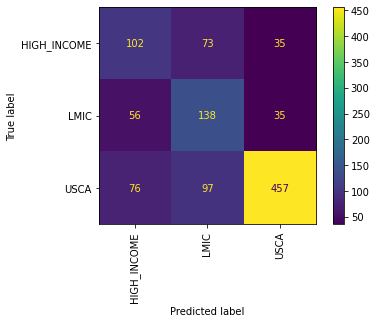

In [ ]:
ConfusionMatrixDisplay.from_predictions(country_ground_truths, pred_country, labels=labels)
plt.xticks(rotation=90)
;

In [ ]:
all_aucs = []
from sklearn.metrics import roc_auc_score
for i in labels:
  roc_auc = roc_auc_score(country_ground_truths == i, [p[i] for p in predictions])
  print (f"SAP ROC AUC {roc_auc} for {i} countries")
  all_aucs.append(roc_auc)
print ("Average", np.mean(all_aucs))

SAP ROC AUC 0.7377986584622207 for HIGH_INCOME countries
SAP ROC AUC 0.7551206071948431 for LMIC countries
SAP ROC AUC 0.8431988285063456 for USCA countries
Average 0.7787060313878031


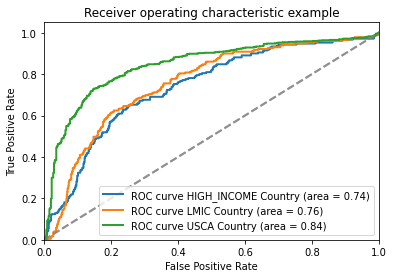

In [ ]:
plt.figure()
lw = 2
    
for i in labels:
    fpr, tpr, _ = roc_curve(country_ground_truths == i, [p[i] for p in predictions])
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        # color="darkorange",
        lw=lw,
        label=f"ROC curve {i} Country (area = {roc_auc:0.2f})"
    )
    plt.plot([0, 1], [0, 1], color="gray", alpha=0.5, lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()